# Libraries

In [1]:
pip install numpy pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To do

In [3]:
def production(strategy,demand,desired_ending_inventory,starting_inventory,desired_month,overtime,percentage_overtime):
    
    # Calculate the required_production_per_month based on the strategy
    if strategy == 1:  # Level Production Strategy
        required_production_per_month = sum(demand)/len(demand)

    elif strategy == 2:  # Chase Strategy
        required_production_per_month = demand[desired_month -1]
        
    elif strategy == 3:  # Mixed Strategy
        required_production_per_month = (sum(demand) /(len(demand) + sum(o * percentage_overtime for o in overtime)))

    return required_production_per_month

# Main function

In [4]:
def calculate_costs_and_inventory(t, produced_units, workers, regular_wage_per_worker, inventory, demand, inventory_cost_per_liter, total_wage_cost, total_inventory_cost):
    wage_cost = workers[t] * regular_wage_per_worker
    inventory[t + 1] = inventory[t] + produced_units - demand[t]
    inventory_cost = inventory[t + 1] * inventory_cost_per_liter
    
    total_wage_cost += wage_cost
    total_inventory_cost += inventory_cost

    return wage_cost, inventory_cost

def update_results(t, produced_units, wage_cost, inventory_cost, hiring_cost, layoff_cost, overtime_cost, workers, hired_workers, laid_off_workers,\
                   demand, inventory, results):
    total_monthly_cost = wage_cost + inventory_cost + hiring_cost + layoff_cost + overtime_cost
    
    results['Month'].append(t + 1)
    results['Regular Workers'].append(workers[t])
    results['Hired Workers'].append(hired_workers[t])
    results['Laid-off Workers'].append(laid_off_workers[t])
    results['Units Produced'].append(produced_units)
    results['Demand'].append(demand[t])
    results['End Inventory'].append(inventory[t + 1])
    results['Wage Cost (in 1000s)'].append(wage_cost)
    results['Overtime Cost (in 1000s)'].append(overtime_cost)
    results['Hiring Cost (in 1000s)'].append(hiring_cost)
    results['Layoff Cost (in 1000s)'].append(layoff_cost)
    results['Inventory Cost (in 1000s)'].append(inventory_cost)
    results['Total Cost (in 1000s)'].append(total_monthly_cost)

def calculate_total_cost(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_liter, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime):

    # Initialize variables
    inventory = np.zeros(months + 1)  # Inventory levels for each month
    inventory[0] = starting_inventory  # Set starting inventory
    workers = np.zeros(months)  # Workers in each month
    hired_workers = np.zeros(months)  # Workers hired in each month
    laid_off_workers = np.zeros(months)  # Workers laid off in each month

    # Tracking costs
    total_wage_cost = 0
    total_inventory_cost = 0
    total_overtime_cost = 0

    # Results table
    results = {
        'Month': [], 'Regular Workers': [], 'Hired Workers': [], 'Laid-off Workers': [],
        'Units Produced': [], 'Demand': [], 'End Inventory': [], 'Wage Cost (in 1000s)': [],
        'Overtime Cost (in 1000s)': [], 'Hiring Cost (in 1000s)': [], 'Layoff Cost (in 1000s)': [],
        'Inventory Cost (in 1000s)': [], 'Total Cost (in 1000s)': []
    }


    # Define overtime percentage for each month (e.g., 0.0 for no overtime, 0.2 for 20% overtime)
    overtime = [0.0] * months  # Initialize overtime to 0 for all months
    
    # Overtime is only used for Strategy 3 (Mixed Strategy)
    if strategy == 3:
        overtime = [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 0.0, 0.0, 0.0, 0.0]  # Month with overtime for Mixed Strategy months

    for desired_month in range(1,1+months):
        required_production_per_month = production(strategy,demand,desired_ending_inventory,starting_inventory,desired_month,overtime,percentage_overtime)
        workers[desired_month-1] = int(np.ceil(required_production_per_month/production_per_worker_per_month_regular))  # Round up to the nearest whole number
            
        # Calculate hiring and layoffs based on previous workers
        t = desired_month - 1
        if t == 0:  # First month
            hired_workers[t] = max(0, workers[t] - initial_workers)  # Compare with initial workers
            laid_off_workers[t] = max(0, initial_workers - workers[t])  # Compare with initial workers
        else:
            hired_workers[t] = max(0, workers[t] - workers[t-1])  # Compare to previous month
            laid_off_workers[t] = max(0, workers[t-1] - workers[t])  # Compare to previous month
            
        # Calculate total hiring and layoff costs
        hiring_cost = hired_workers[t] * hiring_cost_per_worker
        layoff_cost = laid_off_workers[t] * layoff_cost_per_worker
        
        # Update produced units with overtime percentage
        produced_units = workers[t] * production_per_worker_per_month_regular * (1 + overtime[t] * percentage_overtime)

        # Wage cost
        wage_cost, inventory_cost = calculate_costs_and_inventory(t, produced_units, workers, regular_wage_per_worker, inventory, demand, \
                                                                  inventory_cost_per_liter, total_wage_cost, total_inventory_cost)

        # Calculate overtime cost only for Mixed Strategy
        overtime_cost = 0
        if strategy == 3:
            overtime_cost = workers[t] * overtime[t] * percentage_overtime * regular_wage_per_worker * overtime_wage_multiplier
            total_overtime_cost += overtime_cost

        
        update_results(t, produced_units, wage_cost, inventory_cost, hiring_cost, layoff_cost, overtime_cost, workers, hired_workers, \
                       laid_off_workers, demand, inventory, results)

    return results

In [5]:
# Parameters
demand = [300, 300, 350, 400, 450, 500, 650, 600, 475, 475, 450, 450]  # Demand per month (in thousand liters)
months = len(demand)
production_per_worker_per_month_regular = 10  # Each worker produces 10,000 liters per month
starting_inventory = 50  # Starting inventory in thousand liters
desired_ending_inventory = 50  # Desired ending inventory at year-end in thousand liters
inventory_cost_per_liter = 0.06  # Inventory cost per liter
production_cost_per_liter = 2  # Production cost per liter
regular_wage_per_worker = 2  # Wage cost per worker per month
overtime_wage_multiplier = 1.5  # Overtime pay multiplier
hiring_cost_per_worker = 1  # Hiring cost per worker
layoff_cost_per_worker = 2  # Layoff cost per worker
initial_workers = 40  # Initial number of workers for all strategies
percentage_overtime = 0.2


# Ask the user to choose a strategy
print("Choose a strategy:")
print("1. Level Production Strategy (Constant Workers)")
print("2. Chase Strategy (Workers vary with demand)")
print("3. Mixed Strategy (Regular and Overtime)")
strategy = int(input("Enter the strategy number (1, 2, or 3): "))

results = calculate_total_cost(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_liter, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime)

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
print("\nResults Summary:")
display(results_df)

# Total costs overview
total_cost = results_df['Total Cost (in 1000s)'].sum()
print(f"\nTotal Costs for the year (in 1000s): {total_cost}")


Choose a strategy:
1. Level Production Strategy (Constant Workers)
2. Chase Strategy (Workers vary with demand)
3. Mixed Strategy (Regular and Overtime)

Results Summary:


,Month,Regular Workers,Hired Workers,Laid-off Workers,Units Produced,Demand,End Inventory,Wage Cost (in 1000s),Overtime Cost (in 1000s),Hiring Cost (in 1000s),Layoff Cost (in 1000s),Inventory Cost (in 1000s),Total Cost (in 1000s)
0,1,30.0,0.0,10.0,300.0,300,50.0,60.0,0,0.0,20.0,3.0,83.0
1,2,30.0,0.0,0.0,300.0,300,50.0,60.0,0,0.0,0.0,3.0,63.0
2,3,35.0,5.0,0.0,350.0,350,50.0,70.0,0,5.0,0.0,3.0,78.0
3,4,40.0,5.0,0.0,400.0,400,50.0,80.0,0,5.0,0.0,3.0,88.0
4,5,45.0,5.0,0.0,450.0,450,50.0,90.0,0,5.0,0.0,3.0,98.0
5,6,50.0,5.0,0.0,500.0,500,50.0,100.0,0,5.0,0.0,3.0,108.0
6,7,65.0,15.0,0.0,650.0,650,50.0,130.0,0,15.0,0.0,3.0,148.0
7,8,60.0,0.0,5.0,600.0,600,50.0,120.0,0,0.0,10.0,3.0,133.0
8,9,48.0,0.0,12.0,480.0,475,55.0,96.0,0,0.0,24.0,3.3,123.3
9,10,48.0,0.0,0.0,480.0,475,60.0,96.0,0,0.0,0.0,3.6,99.6



Total Costs for the year (in 1000s): 1215.1


# Sensitivity analysis

## Inventory cost


Simulation Results (Total Costs in 1000s for each Strategy and Inventory Cost):


,Level,Chase,Mixed
Inventory Cost,,,
0.01,1115.25,1183.35,1142.53
0.02,1145.50,1189.70,1172.66
0.03,1175.75,1196.05,1202.79
0.04,1206.00,1202.40,1232.92
0.05,1236.25,1208.75,1263.05
0.06,1266.50,1215.10,1293.18
0.07,1296.75,1221.45,1323.31
0.08,1327.00,1227.80,1353.44
0.09,1357.25,1234.15,1383.57


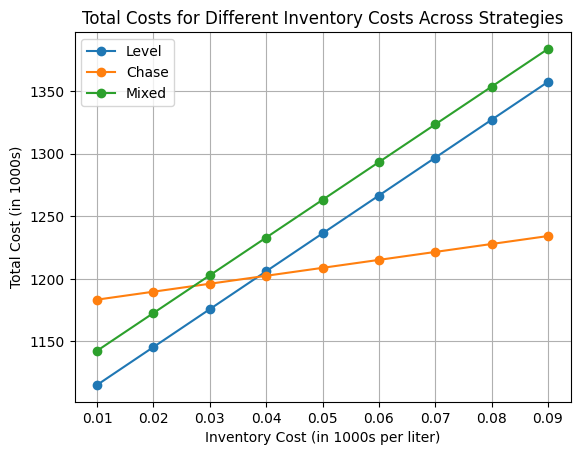

In [6]:
# Inventory cost levels to test (as part of the simulation)
inventory_costs_to_test = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# Now loop over different inventory costs and run the simulation for each strategy
results_summary = []

for inventory_cost_per_liter in inventory_costs_to_test:
    for strategy in [1, 2, 3]:  # Strategy 1 = Level, 2 = Chase, 3 = Mixed

        results =  calculate_total_cost(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_liter, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime)
        total_cost = pd.DataFrame(results)['Total Cost (in 1000s)'].sum()

        results_summary.append({
            'Inventory Cost': inventory_cost_per_liter,
            'Strategy': strategy,
            'Total Cost (in 1000s)': total_cost
        })

# Convert summary to DataFrame for better readability
summary_df = pd.DataFrame(results_summary)

# Pivot the results DataFrame to display in column format
summary_pivot_df = summary_df.pivot(index='Inventory Cost', columns='Strategy', values='Total Cost (in 1000s)')

# Rename the columns for clarity
summary_pivot_df.columns = ['Level', 'Chase', 'Mixed']

# Print the summary table
print("\nSimulation Results (Total Costs in 1000s for each Strategy and Inventory Cost):")
display(summary_pivot_df)


# Call the plotting function
summary_pivot_df.plot(kind='line', marker='o')
plt.title('Total Costs for Different Inventory Costs Across Strategies')
plt.xlabel('Inventory Cost (in 1000s per liter)')
plt.ylabel('Total Cost (in 1000s)')
plt.grid(True)
plt.show()


# Your presentation code

In [24]:
#Parameters

demand = [600, 700, 400, 500, 300]
months = len(demand)
production_per_worker_per_month_regular = 100  # Each worker produces 10,000 liters per month
starting_inventory = 200  # Starting inventory in thousand liters
desired_ending_inventory = 200  # Desired ending inventory at year-end in thousand liters
inventory_cost_per_puzzle = 0.05  # Inventory cost per liter
regular_wage_per_worker = 4  # Wage cost per worker per month
overtime_wage_multiplier = 1.7  # Overtime pay multiplier
hiring_cost_per_worker = 1.5  # Hiring cost per worker
layoff_cost_per_worker = 4  # Layoff cost per worker
initial_workers = 10  # Initial number of workers for all strategies
percentage_overtime = 0.5


In [25]:
def calculate_costs_and_inventory_2(t, produced_units, workers, regular_wage_per_worker, inventory, demand, inventory_cost_per_puzzle, total_wage_cost, total_inventory_cost):
    wage_cost = workers[t] * regular_wage_per_worker
    # Update inventory, ensuring it never goes negative
    inventory[t + 1] = max(0,inventory[t] + produced_units - demand[t])

# Compute costs
    inventory_cost = inventory[t + 1] * inventory_cost_per_puzzle
    total_wage_cost += wage_cost
    total_inventory_cost += inventory_cost


    return wage_cost, inventory_cost

In [26]:
''' 
This code is if we don't answer for all of the demand, but as we can't have a negative inventory, we don't let it go under 0'''
def production(strategy,demand,desired_ending_inventory,starting_inventory,desired_month,overtime,percentage_overtime):
    
    # Calculate the required_production_per_month based on the strategy
    if strategy == 1:  # Level Production Strategy
        required_production_per_month = sum(demand)/len(demand) +100

    elif strategy == 2:  # Chase Strategy
        required_production_per_month = demand[desired_month -1]
        
    elif strategy == 3:  # Mixed Strategy
        required_production_per_month = (sum(demand) /(len(demand) + sum(o * percentage_overtime for o in overtime)))

    return required_production_per_month

def update_results_2(t, produced_units, wage_cost, inventory_cost, hiring_cost, layoff_cost, overtime_cost, workers, hired_workers, laid_off_workers,\
                   demand, inventory, results):
    total_monthly_cost = wage_cost + inventory_cost + hiring_cost + layoff_cost + overtime_cost
    
    results['Month'].append(t + 1)
    results['Regular Workers'].append(workers[t])
    results['Hired Workers'].append(hired_workers[t])
    results['Laid-off Workers'].append(laid_off_workers[t])
    results['Units Produced'].append(produced_units)
    results['Demand'].append(demand[t])
    results['End Inventory'].append(max(0,inventory[t + 1]))
    results['Wage Cost (in 1000s)'].append(wage_cost)
    results['Overtime Cost (in 1000s)'].append(overtime_cost)
    results['Hiring Cost (in 1000s)'].append(hiring_cost)
    results['Layoff Cost (in 1000s)'].append(layoff_cost)
    results['Inventory Cost (in 1000s)'].append(inventory_cost)
    results['Total Cost (in 1000s)'].append(total_monthly_cost)

def calculate_total_cost_2(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_puzzle, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime):

    # Initialize variables
    inventory = np.zeros(months + 1)  # Inventory levels for each month
    inventory[0] = starting_inventory  # Set starting inventory
    workers = np.zeros(months)  # Workers in each month
    hired_workers = np.zeros(months)  # Workers hired in each month
    laid_off_workers = np.zeros(months)  # Workers laid off in each month

    # Tracking costs
    total_wage_cost = 0
    total_inventory_cost = 0
    total_overtime_cost = 0

    # Results table
    results = {
        'Month': [], 'Regular Workers': [], 'Hired Workers': [], 'Laid-off Workers': [],
        'Units Produced': [], 'Demand': [], 'End Inventory': [], 'Wage Cost (in 1000s)': [],
        'Overtime Cost (in 1000s)': [], 'Hiring Cost (in 1000s)': [], 'Layoff Cost (in 1000s)': [],
        'Inventory Cost (in 1000s)': [], 'Total Cost (in 1000s)': []
    }


    # Define overtime percentage for each month (e.g., 0.0 for no overtime, 0.2 for 20% overtime)
    overtime = [0.0] * months  # Initialize overtime to 0 for all months
    
    

    for desired_month in range(1,1+months):
        required_production_per_month = production(strategy,demand,desired_ending_inventory,starting_inventory,desired_month,overtime,percentage_overtime)
        workers[desired_month-1] = int(np.ceil(required_production_per_month/production_per_worker_per_month_regular))  # Round up to the nearest whole number
            
        # Calculate hiring and layoffs based on previous workers
        t = desired_month - 1
        if t == 0:  # First month
            hired_workers[t] = max(0, workers[t] - initial_workers)  # Compare with initial workers
            laid_off_workers[t] = max(0, initial_workers - workers[t])  # Compare with initial workers
        else:
            hired_workers[t] = max(0, workers[t] - workers[t-1])  # Compare to previous month
            laid_off_workers[t] = max(0, workers[t-1] - workers[t])  # Compare to previous month
            
        # Calculate total hiring and layoff costs
        hiring_cost = hired_workers[t] * hiring_cost_per_worker
        layoff_cost = laid_off_workers[t] * layoff_cost_per_worker
        
        # Update produced units with overtime percentage
        produced_units = workers[t] * production_per_worker_per_month_regular * (1 + overtime[t] * percentage_overtime)

        # Overtime is only used for Strategy 3 (Mixed Strategy)
        # **Dynamic Overtime Calculation (Only When Needed)**
        if strategy == 3 and t < 2:  # Only first 2 months can use overtime
            projected_inventory = inventory[t] + produced_units - demand[t]

            if projected_inventory < 0:  # Inventory would go negative
                deficit = abs(projected_inventory)  # Amount needed to bring inventory to 0

                # **Calculate the exact amount of overtime required**
                max_overtime_units = workers[t] * production_per_worker_per_month_regular * percentage_overtime  # Max 50% boost
                overtime_needed = min(1.0, deficit / max_overtime_units)  # Fraction of max overtime needed

                overtime[t] = overtime_needed  # Store overtime used for this month
                produced_units += overtime_needed * max_overtime_units  # Add overtime production
  # Month with overtime for Mixed Strategy months

        # Wage cost
        wage_cost, inventory_cost = calculate_costs_and_inventory(t, produced_units, workers, regular_wage_per_worker, inventory, demand, \
                                                                  inventory_cost_per_puzzle, total_wage_cost, total_inventory_cost)
        # Update inventory dynamically, ensuring it never goes negative
        inventory[t + 1] = max(0, inventory[t] + produced_units - demand[t])


        # Calculate overtime cost only for Mixed Strategy
        overtime_cost = 0
        if strategy == 3:
            overtime_cost = workers[t] * overtime[t] * percentage_overtime * regular_wage_per_worker * overtime_wage_multiplier
            total_overtime_cost += overtime_cost

        
        update_results(t, produced_units, wage_cost, inventory_cost, hiring_cost, layoff_cost, overtime_cost, workers, hired_workers, \
                       laid_off_workers, demand, inventory, results)

    return results

In [27]:
print("Choose a strategy:")
print("1. Level Production Strategy (Constant Workers)")
print("2. Chase Strategy (Workers vary with demand)")
print("3. Mixed Strategy (Regular and Overtime)")
strategy = int(input("Enter the strategy number (1, 2, or 3): "))

results = calculate_total_cost_2(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_puzzle, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime)

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
print("\nResults Summary:")
display(results_df)

# Total costs overview
total_cost = results_df['Total Cost (in 1000s)'].sum()
print(f"\nTotal Costs for the year (in 1000s): {total_cost}")

Choose a strategy:
1. Level Production Strategy (Constant Workers)
2. Chase Strategy (Workers vary with demand)
3. Mixed Strategy (Regular and Overtime)

Results Summary:


,Month,Regular Workers,Hired Workers,Laid-off Workers,Units Produced,Demand,End Inventory,Wage Cost (in 1000s),Overtime Cost (in 1000s),Hiring Cost (in 1000s),Layoff Cost (in 1000s),Inventory Cost (in 1000s),Total Cost (in 1000s)
0,1,5.0,0.0,5.0,500.0,600,100.0,20.0,0.0,0.0,20.0,5.0,45.0
1,2,5.0,0.0,0.0,600.0,700,0.0,20.0,6.8,0.0,0.0,0.0,26.8
2,3,5.0,0.0,0.0,500.0,400,100.0,20.0,0.0,0.0,0.0,5.0,25.0
3,4,5.0,0.0,0.0,500.0,500,100.0,20.0,0.0,0.0,0.0,5.0,25.0
4,5,5.0,0.0,0.0,500.0,300,300.0,20.0,0.0,0.0,0.0,15.0,35.0



Total Costs for the year (in 1000s): 156.8


In [28]:
strategy = int(input("Enter the strategy number (1, 2, or 3): "))

results = calculate_total_cost_2(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_puzzle, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime)

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
print("\nResults Summary:")
display(results_df)

# Total costs overview
total_cost = results_df['Total Cost (in 1000s)'].sum()
print(f"\nTotal Costs for the year (in 1000s): {total_cost}")


Results Summary:


,Month,Regular Workers,Hired Workers,Laid-off Workers,Units Produced,Demand,End Inventory,Wage Cost (in 1000s),Overtime Cost (in 1000s),Hiring Cost (in 1000s),Layoff Cost (in 1000s),Inventory Cost (in 1000s),Total Cost (in 1000s)
0,1,6.0,0.0,4.0,600.0,600,200.0,24.0,0,0.0,16.0,10.0,50.0
1,2,7.0,1.0,0.0,700.0,700,200.0,28.0,0,1.5,0.0,10.0,39.5
2,3,4.0,0.0,3.0,400.0,400,200.0,16.0,0,0.0,12.0,10.0,38.0
3,4,5.0,1.0,0.0,500.0,500,200.0,20.0,0,1.5,0.0,10.0,31.5
4,5,3.0,0.0,2.0,300.0,300,200.0,12.0,0,0.0,8.0,10.0,30.0



Total Costs for the year (in 1000s): 189.0


In [29]:
strategy = int(input("Enter the strategy number (1, 2, or 3): "))

results = calculate_total_cost_2(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_puzzle, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime)

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
print("\nResults Summary:")
display(results_df)

# Total costs overview
total_cost = results_df['Total Cost (in 1000s)'].sum()
print(f"\nTotal Costs for the year (in 1000s): {total_cost}")


Results Summary:


,Month,Regular Workers,Hired Workers,Laid-off Workers,Units Produced,Demand,End Inventory,Wage Cost (in 1000s),Overtime Cost (in 1000s),Hiring Cost (in 1000s),Layoff Cost (in 1000s),Inventory Cost (in 1000s),Total Cost (in 1000s)
0,1,6.0,0.0,4.0,600.0,600,200.0,24.0,0,0.0,16.0,10.0,50.0
1,2,6.0,0.0,0.0,600.0,700,100.0,24.0,0,0.0,0.0,5.0,29.0
2,3,6.0,0.0,0.0,600.0,400,300.0,24.0,0,0.0,0.0,15.0,39.0
3,4,6.0,0.0,0.0,600.0,500,400.0,24.0,0,0.0,0.0,20.0,44.0
4,5,6.0,0.0,0.0,600.0,300,700.0,24.0,0,0.0,0.0,35.0,59.0



Total Costs for the year (in 1000s): 221.0



Simulation Results (Total Costs in 1000s for each Strategy and Inventory Cost):


,Level,Chase,Mixed
Inventory Cost,,,
0.01,153.0,149.0,132.8
0.02,170.0,159.0,138.8
0.03,187.0,169.0,144.8
0.04,204.0,179.0,150.8
0.05,221.0,189.0,156.8
0.06,238.0,199.0,162.8
0.07,255.0,209.0,168.8
0.08,272.0,219.0,174.8
0.09,289.0,229.0,180.8


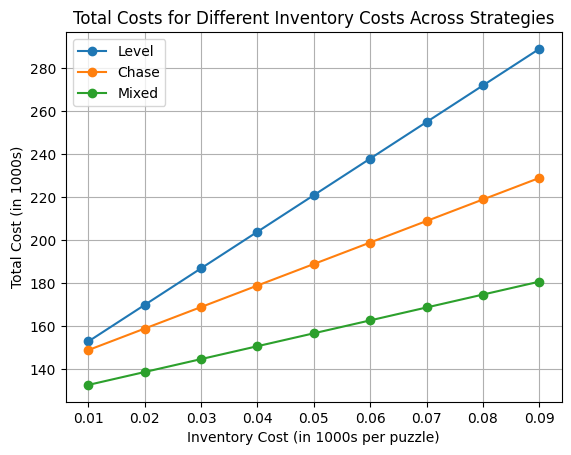

In [31]:
# Inventory cost levels to test (as part of the simulation)
inventory_costs_to_test = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# Now loop over different inventory costs and run the simulation for each strategy
results_summary = []

for inventory_cost_per_puzzle in inventory_costs_to_test:
    for strategy in [1, 2, 3]:  # Strategy 1 = Level, 2 = Chase, 3 = Mixed

        results =  calculate_total_cost_2(strategy, demand, months, production_per_worker_per_month_regular, starting_inventory, desired_ending_inventory, \
                               inventory_cost_per_puzzle, regular_wage_per_worker, overtime_wage_multiplier, \
                                hiring_cost_per_worker, layoff_cost_per_worker, initial_workers, percentage_overtime)
        total_cost = pd.DataFrame(results)['Total Cost (in 1000s)'].sum()

        results_summary.append({
            'Inventory Cost': inventory_cost_per_puzzle,
            'Strategy': strategy,
            'Total Cost (in 1000s)': total_cost
        })

# Convert summary to DataFrame for better readability
summary_df = pd.DataFrame(results_summary)

# Pivot the results DataFrame to display in column format
summary_pivot_df = summary_df.pivot(index='Inventory Cost', columns='Strategy', values='Total Cost (in 1000s)')

# Rename the columns for clarity
summary_pivot_df.columns = ['Level', 'Chase', 'Mixed']

# Print the summary table
print("\nSimulation Results (Total Costs in 1000s for each Strategy and Inventory Cost):")
display(summary_pivot_df)


# Call the plotting function
summary_pivot_df.plot(kind='line', marker='o')
plt.title('Total Costs for Different Inventory Costs Across Strategies')
plt.xlabel('Inventory Cost (in 1000s per puzzle)')
plt.ylabel('Total Cost (in 1000s)')
plt.grid(True)
plt.show()